# Sampling From Groundtruth

In [68]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import bbobtorch
import pyswarms as ps

## Create Groundtruth Functions

In [69]:
n_dim = 2
n_samples = 1000
f_number = 24
seed = 42

In [103]:
def create_problem(f_number, n_dim, seed):
    if f_number == 1:
        problem = bbobtorch.create_f01(n_dim, seed=seed)
    elif f_number == 3:
        problem = bbobtorch.create_f03(n_dim, seed=seed)
    elif f_number == 24:
        problem = bbobtorch.create_f24(n_dim, seed=seed)
    else:
        raise ValueError('We only use BBOB functions be 1, 3 and 24')
    
    return problem

In [71]:
problem_1 = create_problem(1, n_dim, seed)
problem_3 = create_problem(3, n_dim, seed)
problem_24 = create_problem(24, n_dim, seed)

c:\ProgramData\Anaconda3\envs\python-3-10-env\MachineLearningProject\lib\site-packages\bbobtorch\utils.py:44: UserWarning: torch.qr is deprecated in favor of torch.linalg.qr and will be removed in a future PyTorch release.
The boolean parameter 'some' has been replaced with a string parameter 'mode'.
Q, R = torch.qr(A, some)
should be replaced with
Q, R = torch.linalg.qr(A, 'reduced' if some else 'complete') (Triggered internally at ..\aten\src\ATen\native\BatchLinearAlgebra.cpp:2431.)
  R, _ = t.qr(R)


In [113]:
# plotting works only with 2D problems
def plot_groundtruth(problem, xlim=(-5,5), step=0.01):
    ranges = [torch.arange(xlim[0], xlim[1] + step, step=step) for _ in range(n_dim)]
    meshgrid = torch.meshgrid(*ranges)
    points = torch.stack(meshgrid, dim=-1).view(-1, n_dim)

    results = problem(points)

    grid_size = int((xlim[1] - xlim[0]) / step) + 1
    x = points[:, 0].reshape(grid_size, grid_size)
    y = points[:, 1].reshape(grid_size, grid_size)
    z = results.reshape(grid_size, grid_size)

    # Create a pcolormesh plot
    plt.pcolormesh(x, y, z, cmap='inferno', shading='nearest')
    plt.colorbar()
    plt.plot(problem.x_opt[0], problem.x_opt[1], 'rx', markersize=10, label='x_opt')

    plt.xlabel('X')
    plt.ylabel('Y')
    
    return plt.gca()

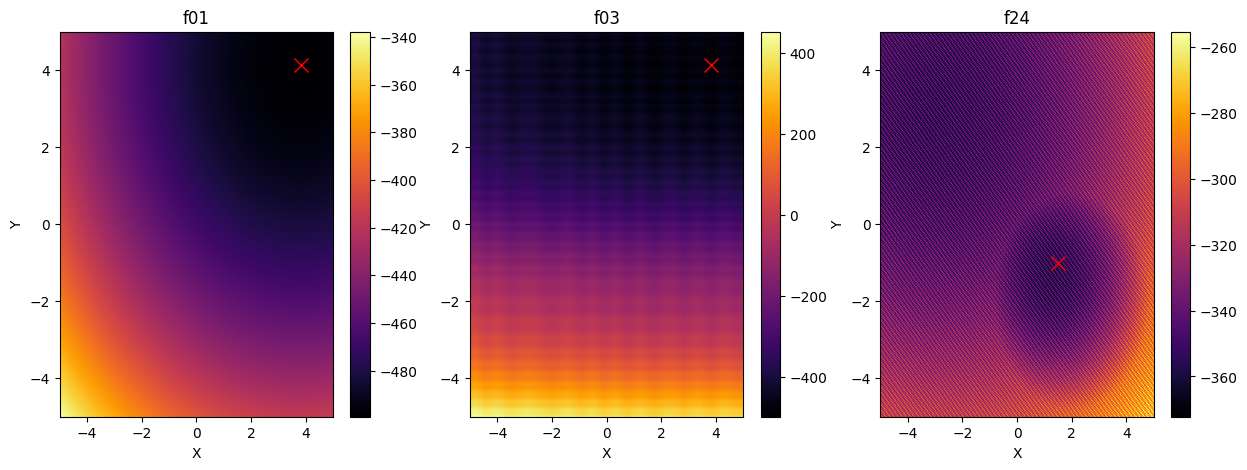

In [114]:
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.title("f01")
plot_groundtruth(problem_1)
plt.subplot(1,3,2)
plt.title("f03")
plot_groundtruth(problem_3)
plt.subplot(1,3,3)
plt.title("f24")
plot_groundtruth(problem_24)
plt.show()

## Sample From Groundtruth

### Sampling with PSO

In [115]:
def sample_from_problem_with_pso(problem, 
                                 n_dim, 
                                 seed, 
                                 n_samples=5000, 
                                 particles=20, 
                                 iters=250, 
                                 options={'c1': 0.8, 'c2': 0.3, 'w': 0.95},
                                 bounds=[np.array([-5] * n_dim), np.array([5] * n_dim)]):
    if n_samples != particles * iters:
        raise ValueError('n_samples must be equal to particles * iters')
    np.random.seed(seed)
    options = options
    optimizer = ps.single.GlobalBestPSO(n_particles=particles, dimensions=n_dim, options=options, bounds=(bounds[0], bounds[1]))
    optimizer.optimize(lambda x: problem(torch.tensor(x, dtype=torch.float32)).numpy(), iters=iters, verbose=False)
    samples = np.array(optimizer.pos_history).reshape((n_samples, 2))

    return samples


In [116]:
samples_1 = sample_from_problem_with_pso(problem_1, n_dim, seed)
samples_3 = sample_from_problem_with_pso(problem_3, n_dim, seed)
samples_24 = sample_from_problem_with_pso(problem_24, n_dim, seed)

In [117]:
def plot_samples(samples, problem, xlim=(-5,5), step=0.01):
    ranges = [torch.arange(xlim[0], xlim[1] + step, step=step) for _ in range(n_dim)]
    meshgrid = torch.meshgrid(*ranges)
    points = torch.stack(meshgrid, dim=-1).view(-1, n_dim)

    results = problem(points)

    grid_size = int((xlim[1] - xlim[0]) / step) + 1
    x = points[:, 0].reshape(grid_size, grid_size)
    y = points[:, 1].reshape(grid_size, grid_size)
    z = results.reshape(grid_size, grid_size)

    # Create a pcolormesh plot
    plt.pcolormesh(x, y, z, cmap='inferno', shading='nearest')
    plt.colorbar()
    plt.plot(problem.x_opt[0], problem.x_opt[1], 'rx', markersize=10, label='x_opt')
    
    plt.scatter(samples[:,0], samples[:,1], marker='.', c='w', s=1)

    plt.xlabel('X')
    plt.ylabel('Y')


    
    return plt.gca()

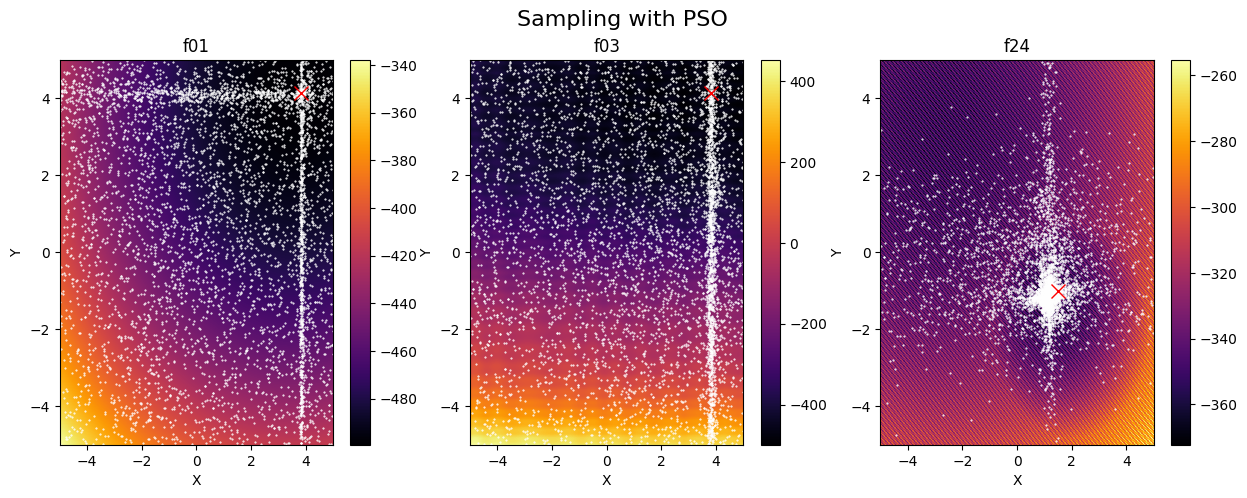

In [118]:
plt.figure(figsize=(15,5))
plt.suptitle("Sampling with PSO", fontsize=16)
plt.subplot(1,3,1)
plt.title("f01")
plot_samples(samples_1, problem_1)
plt.subplot(1,3,2)
plt.title("f03")
plot_samples(samples_3, problem_3)
plt.subplot(1,3,3)
plt.title("f24")
plot_samples(samples_24, problem_24)
plt.show()

### Random Sampling

In [119]:
def random_sample(n_samples, n_dim, seed, bounds=5):
    np.random.seed(seed)
    samples_random = (torch.rand(n_samples, n_dim)-0.5)*2*bounds
    return samples_random

In [120]:
samples_1_r = random_sample(5000, n_dim, seed)
samples_3_r = random_sample(5000, n_dim, seed)
samples_24_r = random_sample(5000, n_dim, seed)

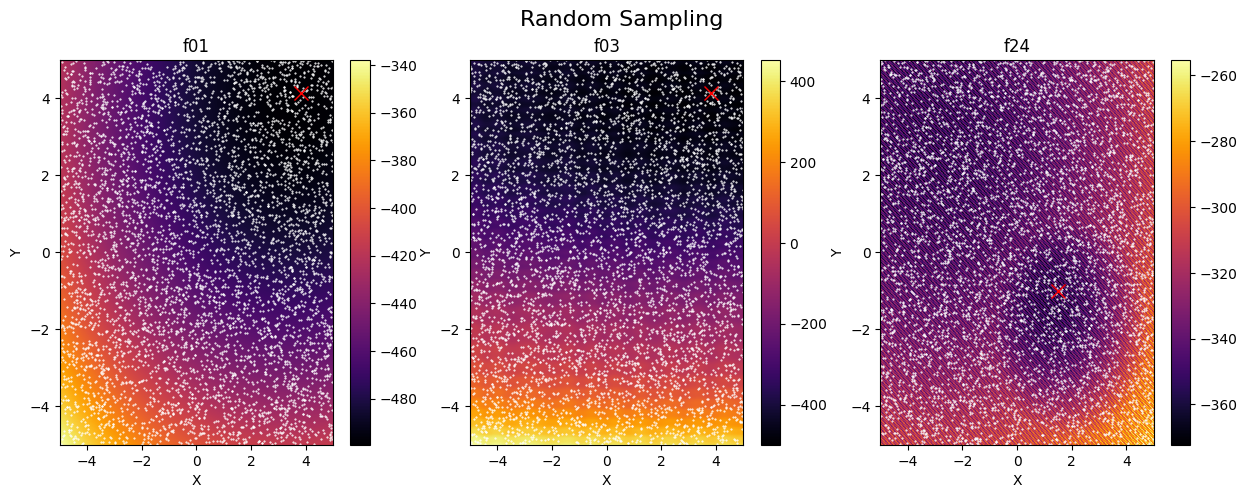

In [121]:
plt.figure(figsize=(15,5))
plt.suptitle("Random Sampling", fontsize=16)
plt.subplot(1,3,1)
plt.title("f01")
plot_samples(samples_1_r, problem_1)
plt.subplot(1,3,2)
plt.title("f03")
plot_samples(samples_3_r, problem_3)
plt.subplot(1,3,3)
plt.title("f24")
plot_samples(samples_24_r, problem_24)
plt.show()

## Fazit

ach kp